### Predicting the closeing price of a stock using Arima and facebook's Prophet

In [3]:
# Import dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pandas_datareader import DataReader
import datetime  
import math
from sklearn.metrics import r2_score
import yfinance as yf
from prophet import Prophet
import warnings
warnings.filterwarnings("ignore")

In [4]:

# Defining the ticker and date range.
ticker = "NVDA" 
start_date = datetime.datetime.now() - datetime.timedelta(days=1000)
end_date = datetime.date.today()

# pandas_datareader format 
yf.pdr_override() 

# Download historical data
data = yf.download(ticker, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [5]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-07-01,201.250000,204.559998,200.190002,202.119995,201.771866,48013600
2021-07-02,204.402496,205.052505,202.877502,204.869995,204.517120,34276400
2021-07-06,207.375000,208.419998,203.502502,206.985001,206.628479,44670800
2021-07-07,208.535004,208.750000,203.320007,203.717499,203.366623,41842800
2021-07-08,198.565002,201.330002,197.007507,199.027496,198.684677,50330000
...,...,...,...,...,...,...
2024-03-20,897.969971,904.099976,882.229980,903.719971,903.719971,47906300
2024-03-21,923.000000,926.479980,904.049988,914.349976,914.349976,48037200
2024-03-22,911.409973,947.780029,908.340027,942.890015,942.890015,58521500


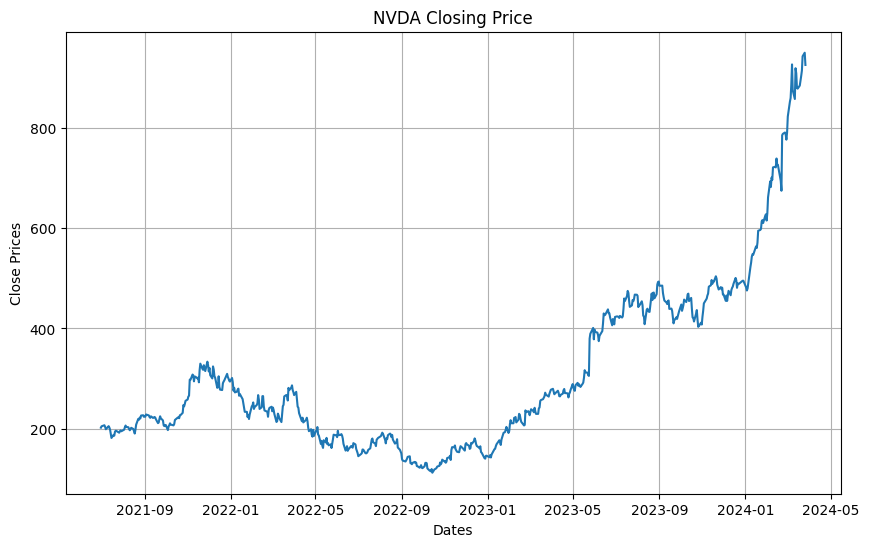

In [6]:
# Plot the closing price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Close Prices')
plt.plot(data['Close'])
plt.title(f"{ticker} Closing Price")
plt.show()

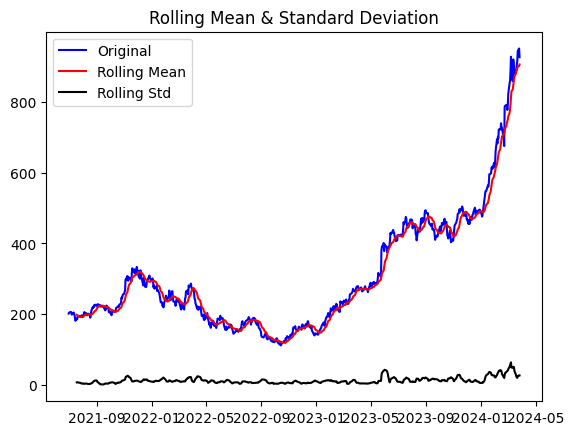

Results of Dickey Fuller Test
Test Statistics                  3.681778
p-value                          1.000000
No. of lags used                 2.000000
Number of observations used    685.000000
critical value (1%)             -3.439932
critical value (5%)             -2.865769
critical value (10%)            -2.569022
dtype: float64


In [7]:
# Test for stationarity
def test_stationarity(timeseries):
    # Rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    
    # Plot rolling statistics
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Dickey-Fuller Test
    print("Results of Dickey Fuller Test")
    adft = adfuller(timeseries, autolag='AIC')
    output = pd.Series(adft[0:4], index=['Test Statistics', 'p-value', 'No. of lags used', 'Number of observations used'])
    for key, value in adft[4].items():
        output[f'critical value ({key})'] = value
    print(output)
    
test_stationarity(data['Close'])

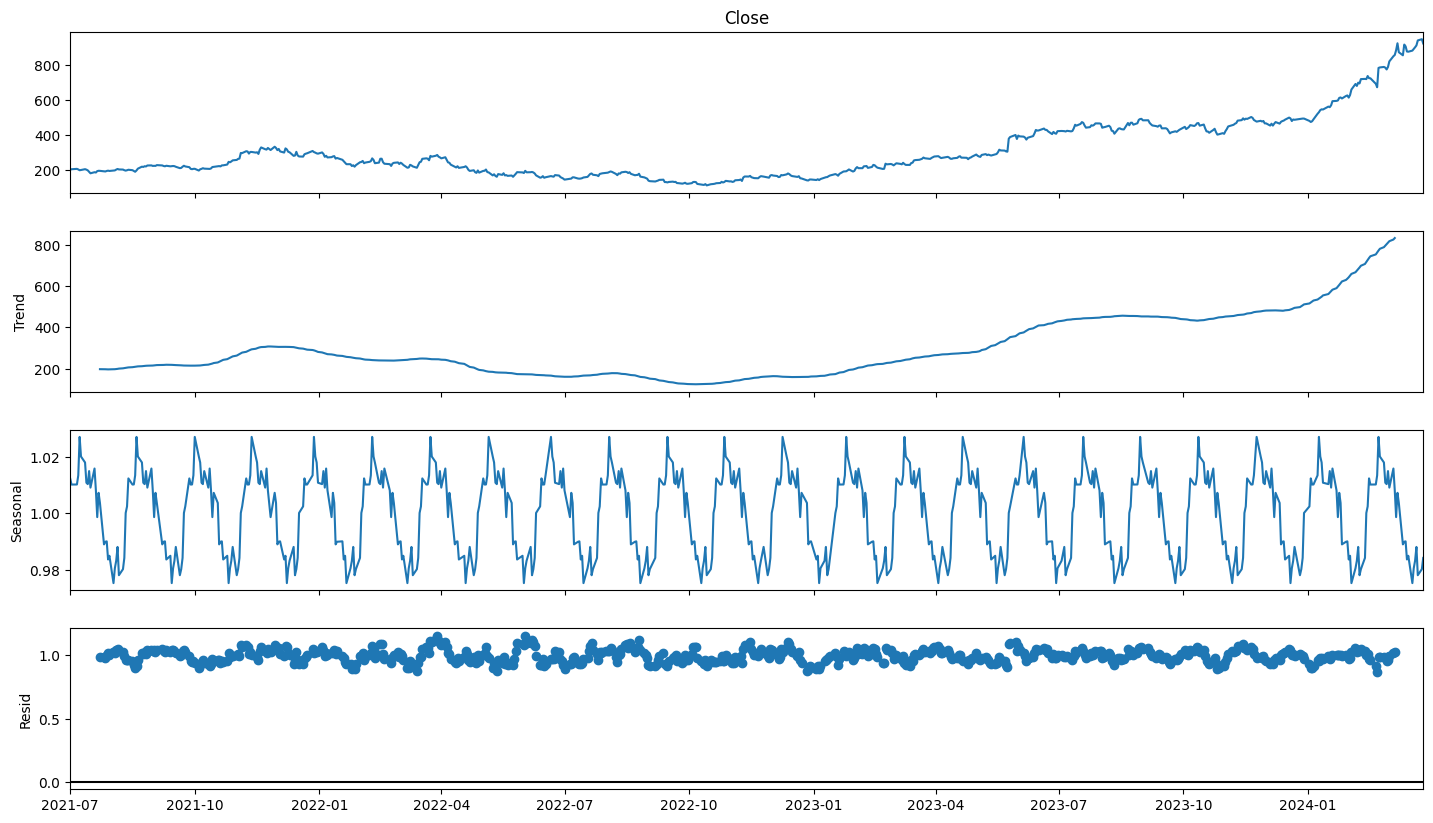

In [8]:
# Decompose the series
result = seasonal_decompose(data['Close'], model='multiplicative',period = 30)
fig = result.plot()  
fig.set_size_inches(16, 9)

In [9]:
# Log transform
df_log = np.log(data['Close'])
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()

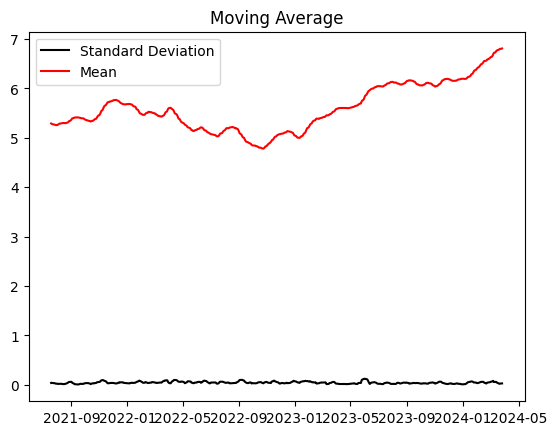

In [10]:
# Plot moving average
plt.plot(std_dev, color='black', label='Standard Deviation')
plt.plot(moving_avg, color='red', label='Mean')
plt.legend()
plt.title('Moving Average')
plt.show()

In [11]:
# Split data into train and test sets
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]

In [12]:
# Build and fit ARIMA model
model = ARIMA(train_data, order=(3, 1, 2))  
fitted = model.fit()  
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  616
Model:                 ARIMA(3, 1, 2)   Log Likelihood                1202.813
Date:                Wed, 27 Mar 2024   AIC                          -2393.627
Time:                        02:17:08   BIC                          -2367.097
Sample:                             0   HQIC                         -2383.311
                                - 616                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7575      0.283      2.678      0.007       0.203       1.312
ar.L2         -0.7758      0.250     -3.105      0.002      -1.265      -0.286
ar.L3         -0.0175      0.052     -0.336      0.7

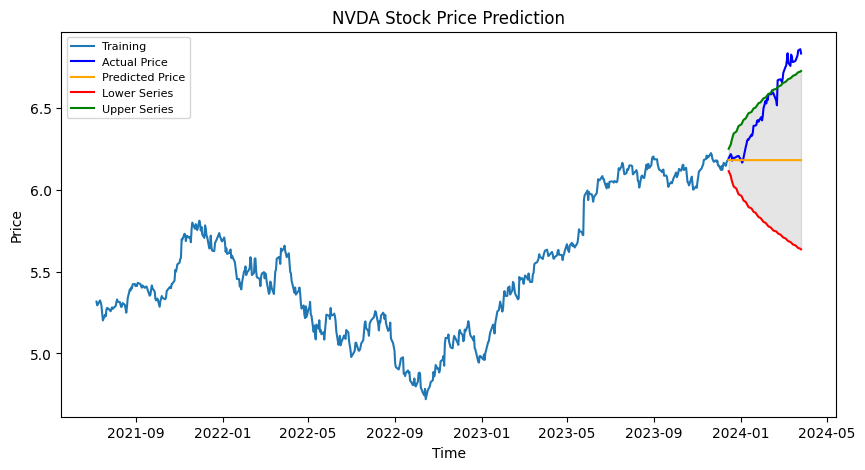

In [13]:
# Forecast
fc = fitted.forecast(len(test_data), alpha = 0.05)
conf_ins = fitted.get_forecast(len(test_data)).summary_frame()


# Setting the index for the forcasted data 
fc.index = test_data.index


# Upper and Lower Series 
lower_series = conf_ins['mean_ci_lower']
lower_series.index = test_data.index
upper_series = conf_ins['mean_ci_upper']
upper_series.index = test_data.index


plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='Training')
plt.plot(test_data, color='blue', label='Actual Price')
plt.plot(fc, color='orange', label='Predicted Price')
plt.plot(lower_series, color='red', label='Lower Series')
plt.plot(upper_series, color='green', label='Upper Series')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.title(f'{ticker} Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Now we convert the data back into its original scale

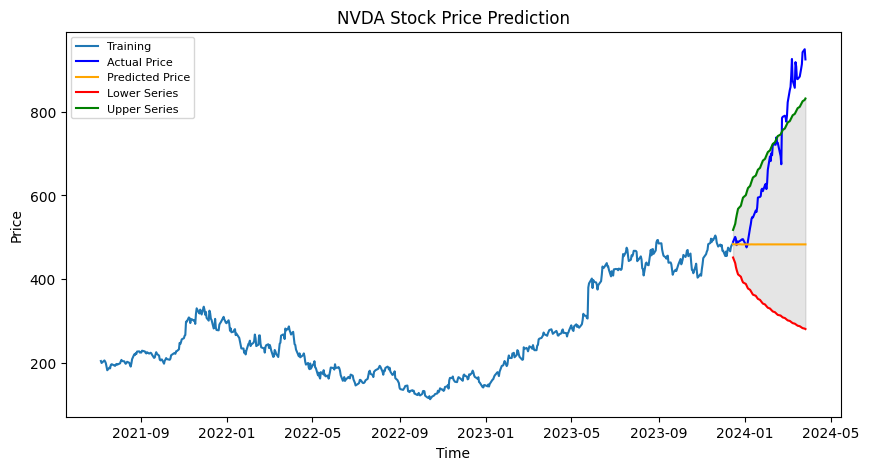

In [14]:
fc = np.exp(fc)
lower_series = np.exp(lower_series)
upper_series = np.exp(upper_series)
train_data = np.exp(train_data)
test_data = np.exp(test_data)


plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='Training')
plt.plot(test_data, color='blue', label='Actual Price')
plt.plot(fc, color='orange', label='Predicted Price')
plt.plot(lower_series, color='red', label='Lower Series')
plt.plot(upper_series, color='green', label='Upper Series')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.title(f'{ticker} Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [15]:
# Performance metrics
mse = mean_squared_error(test_data, fc)
mae = mean_absolute_error(test_data, fc)
rmse = math.sqrt(mse)
print(f'MSE: {mse}, MAE: {mae}, RMSE: {rmse}')

MSE: 64657.007474523176, MAE: 203.44098112033103, RMSE: 254.27742226655354, MAPE: 0.26034665403086693


02:17:09 - cmdstanpy - INFO - Chain [1] start processing
02:17:09 - cmdstanpy - INFO - Chain [1] done processing


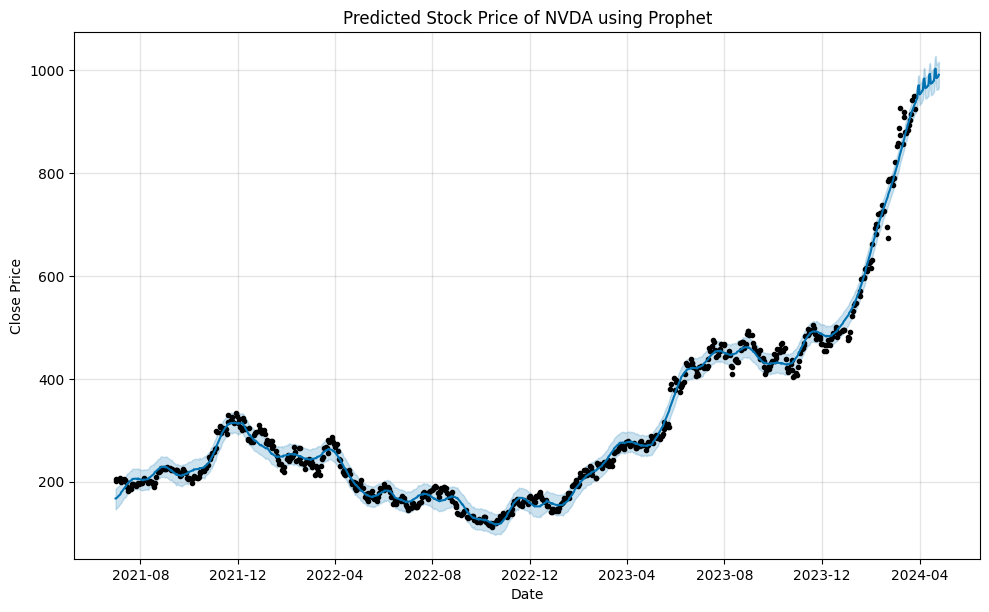

In [17]:
# Prepare data for Prophet model
data.reset_index(inplace=True)
data = data[['Date', 'Close']].rename(columns={'Date': 'ds', 'Close': 'y'})

# Initialize and fit Prophet model
model = Prophet(daily_seasonality=True)
model.fit(data)

# Prepare future dataframe for prediction
future = model.make_future_dataframe(periods=30)

# Make predictions
forecast = model.predict(future)

# Plot predictions
model.plot(forecast)
plt.title(f"Predicted Stock Price of {ticker} using Prophet")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()

Here black dots are the actual price and the blue line is the predicted price

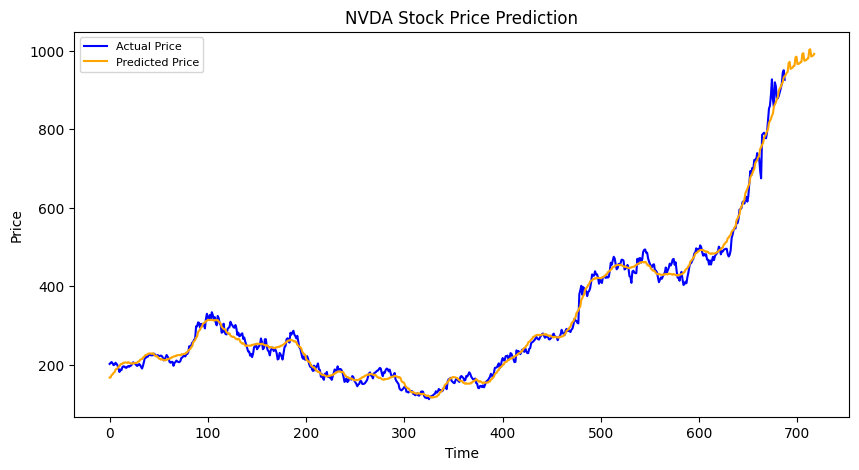

In [25]:
plt.figure(figsize=(10,5), dpi=100)
plt.plot(data['y'], color='blue', label='Actual Price')
plt.plot(forecast['yhat'], color='orange', label='Predicted Price')
plt.title(f'{ticker} Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [31]:

r2_score(data['y'],forecast['yhat'].iloc[:688])

0.9918018638851852

In [37]:
# Performance metrics
mse = mean_squared_error(data['y'],forecast['yhat'].iloc[:688])
mae = mean_absolute_error(data['y'],forecast['yhat'].iloc[:688])
rmse = math.sqrt(mse)
print(f'MSE: {mse}, MAE: {mae}, RMSE: {rmse}')

MSE: 237.97644975340347, MAE: 11.576810975580406, RMSE: 15.4264853337824
